In [29]:
from transformers import DistilBertTokenizer, DistilBertConfig
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

In [6]:
df = pd.read_csv("dataset/combined_GH_HF_manual.csv")

# Function to clean text columns
def clean_text(text):
    # Remove non-ASCII characters (corrupted/malformed characters)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    return text.strip()

# Apply cleaning function to relevant columns
df['message'] = df['message'].apply(clean_text)
df = df[df['message'].notna() & (df['message'] != '') & (df['message'].str.split().str.len() > 1)]
df["label"] = df["label"].str.lower()

number_of_labels = df["label"].value_counts()
number_of_labels

label
external documentation       501
model structure              195
project metadata             141
sharing                      127
preprocessing                 61
training infrastructure       55
validation infrastructure     52
input data                    35
internal documentation        35
pipeline performance          33
parameter tuning              31
add dependency                19
output data                   18
update dependency             17
remove dependency             15
Name: count, dtype: int64

In [9]:
#Get the Unique Items from the label column
df['label'].unique()

array(['training infrastructure', 'add dependency',
       'external documentation', 'input data', 'model structure',
       'preprocessing', 'output data', 'validation infrastructure',
       'internal documentation', 'parameter tuning', 'update dependency',
       'project metadata', 'remove dependency', 'pipeline performance',
       'sharing'], dtype=object)

In [11]:
df['encoded_cat'] = df['label'].astype('category').cat.codes
print(df.head())

       owner                 message                    label  encoded_cat
0       BAAI  Update evaluate_ssc.py  training infrastructure           12
1  microsoft          add dependency           add dependency            0
2   JackFram  [Python]: fix examples   external documentation            1
3   Langboat                add demo   external documentation            1
4       tner             add diagram   external documentation            1


In [15]:
unique_labels = df[["encoded_cat", "label"]].drop_duplicates()
unique_labels

,encoded_cat,label
0,12,training infrastructure
1,0,add dependency
2,1,external documentation
162,2,input data
168,4,model structure
171,8,preprocessing
174,5,output data
179,14,validation infrastructure
186,3,internal documentation
187,6,parameter tuning


In [19]:
data_texts = df["message"].to_list() # Features (not tokenized yet)
data_labels = df["encoded_cat"].to_list() # Labels

In [21]:
# Split Train and Validation data
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)
 
# Keep some data for inference (testing)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

In [22]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels))

In [24]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=15)
 
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(train_dataset.shuffle(1000).batch(16),
epochs=2,
batch_size=16,
validation_data=val_dataset.shuffle(1000).batch(16),
callbacks=[early_stopping])

Epoch 1/2
67/67 [==============================] - 725s 11s/step - loss: 1.9141 - accuracy: 0.4626 - val_loss: 1.4159 - val_accuracy: 0.6517
Epoch 2/2
67/67 [==============================] - 739s 11s/step - loss: 1.3238 - accuracy: 0.6377 - val_loss: 1.1998 - val_accuracy: 0.6779


In [26]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  11535     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66965007 (255.45 MB)
Trainable params: 66965007 (255.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
#config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
save_directory = "./Multitext_Classification_colab" # Change this to your preferred location
 
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)
#config.save_pretrained(save_directory)

('./Multitext_Classification_colab/tokenizer_config.json',
 './Multitext_Classification_colab/special_tokens_map.json',
 './Multitext_Classification_colab/vocab.txt',
 './Multitext_Classification_colab/added_tokens.json')

In [34]:
save_directory = "Multitext_Classification_colab"
loaded_tokenizer = DistilBertTokenizer.from_pretrained(save_directory)
loaded_model = TFDistilBertForSequenceClassification.from_pretrained(save_directory)

Some layers from the model checkpoint at Multitext_Classification_colab were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at Multitext_Classification_colab and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
test_text = test_texts[6]
test_text

'Update client calls to query rules (#322)'

In [55]:
predict_input = loaded_tokenizer.encode(test_text,
truncation=True,
padding=True,
return_tensors="tf")
 
output = loaded_model(predict_input)[0]
 
prediction_value = tf.argmax(output, axis=1).numpy()[0]
prediction_value

1

In [56]:
predict_input = loaded_tokenizer.encode(test_text,
                                        truncation=True,
                                        padding=True,
                                        return_tensors="tf")

output = loaded_model(predict_input)[0]

prediction_value = tf.argmax(output, axis=1).numpy()[0]

# Use if statements to map encoded_cat to the category labels
if prediction_value == 0:
    prediction_label = "add dependency"
elif prediction_value == 1:
    prediction_label = "external documentation"
elif prediction_value == 2:
    prediction_label = "input data"
elif prediction_value == 3:
    prediction_label = "internal documentation"
elif prediction_value == 4:
    prediction_label = "model structure"
elif prediction_value == 5:
    prediction_label = "output data"
elif prediction_value == 6:
    prediction_label = "parameter tuning"
elif prediction_value == 7:
    prediction_label = "pipeline performance"
elif prediction_value == 8:
    prediction_label = "preprocessing"
elif prediction_value == 9:
    prediction_label = "project metadata"
elif prediction_value == 10:
    prediction_label = "remove dependency"
elif prediction_value == 11:
    prediction_label = "sharing"
elif prediction_value == 12:
    prediction_label = "training infrastructure"
elif prediction_value == 13:
    prediction_label = "update dependency"
elif prediction_value == 14:
    prediction_label = "validation infrastructure"
else:
    prediction_label = "Unknown Category"  # Handle unexpected values if necessary

print("🤖 Predicted Category:", prediction_label)

🤖 Predicted Category: external documentation


In [57]:
def predict_category(text):
    # Encode the text and make prediction
    predict_input = loaded_tokenizer.encode(text,
                                            truncation=True,
                                            padding=True,
                                            return_tensors="tf")
    output = loaded_model(predict_input)[0]
    prediction_value = tf.argmax(output, axis=1).numpy()[0]
    return prediction_value

# -------------------------------
y_pred = []
for text_ in test_texts:
    y_pred.append(predict_category(text_))

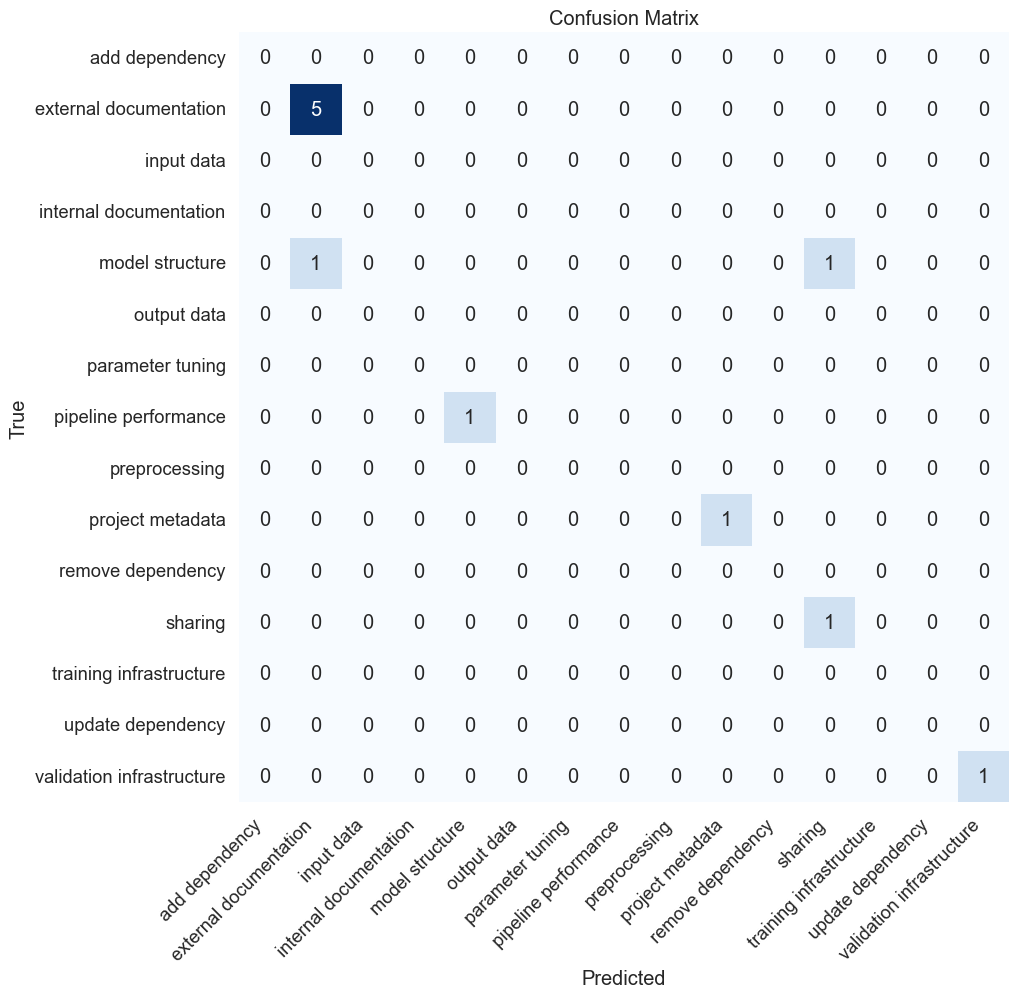

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

category_labels = [
    "add dependency",
    "external documentation",
    "input data",
    "internal documentation",
    "model structure",
    "output data",
    "parameter tuning",
    "pipeline performance",
    "preprocessing",
    "project metadata",
    "remove dependency",
    "sharing",
    "training infrastructure",
    "update dependency",
    "validation infrastructure"
]

# Generate the confusion matrix with all 15 categories
confusion = confusion_matrix(test_labels, y_pred, labels=range(15))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=category_labels, yticklabels=category_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.show()

In [61]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           1       0.83      1.00      0.91         5
           4       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1
          11       0.50      1.00      0.67         1
          14       1.00      1.00      1.00         1

    accuracy                           0.73        11
   macro avg       0.56      0.67      0.60        11
weighted avg       0.61      0.73      0.66        11



/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/adekunleajibode/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [70]:
HF = pd.read_csv("dataset/HF_commit_986.csv")
HF['combine_message'] = HF['title'] + ' ' + HF['message'].fillna(HF['title'])

# Function to clean text columns
def clean_text(text):
    # Remove non-ASCII characters (corrupted/malformed characters)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    return text.strip()

# Apply cleaning function to relevant columns
HF['combine_message'] = HF['combine_message'].apply(clean_text)
HF = HF[HF['combine_message'].notna() & (HF['combine_message'] != '') & (HF['combine_message'].str.split().str.len() > 1)]

In [73]:
HF_data = HF["combine_message"].to_list()
len(HF_data)

17269

In [75]:
HF_predictions = []
for data in HF['combine_message']:  # Assuming 'data' is the column name in your DataFrame
    HF_predictions.append(predict_category(data))

# Create the DataFrame with predictions
prediction_df = pd.DataFrame({
    "data": HF['combine_message'],  # Assuming 'data' is a column in your original DataFrame
    "labels": HF_predictions,
})

# Save the predictions to a CSV file
prediction_df.to_csv("HF_model_prediction.csv", index=False)

In [ ]:
df = pd.read_csv("dataset/combined_GH_HF_manual.csv")

# Function to clean text columns
def clean_text(text):
    # Remove non-ASCII characters (corrupted/malformed characters)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters
    return text.strip()

# Apply cleaning function to relevant columns
df['message'] = df['message'].apply(clean_text)
df = df[df['message'].notna() & (df['message'] != '') & (df['message'].str.split().str.len() > 1)]
df["label"] = df["label"].str.lower()

number_of_labels = df["label"].value_counts()
number_of_labels

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Preprocessing function for the DataFrame
def preprocess_function(text):
    return tokenizer(text, padding="max_length", truncation=True, return_tensors="pt")

# Apply preprocessing on the 'message' column
encoded_dataset = df['message'].apply(preprocess_function)

# Check processed data for the first entry
print(encoded_dataset.iloc[0])

data_texts = df['message'].tolist()  # Your text data
data_labels = df['label'].tolist()  # Your labels

# Split into Train and Validation (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(data_texts, data_labels, test_size=0.2, random_state=0, shuffle=True)

# Further split Train data into Train and Test (99% train, 1% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=0.01, random_state=0, shuffle=True)

# Check the number of items in each split
print(f"Training data: {len(train_texts)}")
print(f"Validation data: {len(val_texts)}")
print(f"Test data: {len(test_texts)}")


tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Preprocessing function to tokenize the data
def preprocess_function(texts):
    return tokenizer(texts, padding="max_length", truncation=True)

# Tokenize the train, validation, and test data
train_encodings = preprocess_function(train_texts)
val_encodings = preprocess_function(val_texts)
test_encodings = preprocess_function(test_texts)

# Check the lengths of the encoded data
print(len(train_encodings["input_ids"]))  # Should match len(train_texts)
print(len(val_encodings["input_ids"]))    # Should match len(val_texts)
print(len(test_encodings["input_ids"]))


train_dataset = [{
    "input_ids": enc, 
    "attention_mask": train_encodings["attention_mask"][i], 
    "labels": train_labels[i]
} for i, enc in enumerate(train_encodings["input_ids"])]

val_dataset = [{
    "input_ids": enc, 
    "attention_mask": val_encodings["attention_mask"][i], 
    "labels": val_labels[i]
} for i, enc in enumerate(val_encodings["input_ids"])]

test_dataset = [{
    "input_ids": enc, 
    "attention_mask": test_encodings["attention_mask"][i], 
    "labels": test_labels[i]
} for i, enc in enumerate(test_encodings["input_ids"])]

# Load DistilBERT model for classification with 15 labels
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=15)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",           # Directory for saving results
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    learning_rate=5e-5,              # Initial learning rate
    per_device_train_batch_size=16,  # Batch size per GPU
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Regularization
    logging_dir="./logs",            # Directory for logs
    logging_steps=10                 # Log every 10 steps
)